In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
torch.set_printoptions(linewidth=120)

In [5]:
train_set=torchvision.datasets.FashionMNIST(
root='./data/FashionMNIST'
, train=True
,download=True
,transform=transforms.Compose([
    transforms.ToTensor()
]))


In the above example we are extracting Fashion MNIST train set and loading it to a loader. The train_loader will be a tuple of images,labels in 100 batches each

In [11]:
image,label=next(iter(train_set))

In [15]:
print(image.shape)
print(label)

torch.Size([1, 28, 28])
9


In the above example train_set is a tensor of tuples, we can iterate over the tuple with next and iter. To get the first element we do next(iter(train_set)) which returns a tuple of an image and the 
corresponding label
But since we need batches of inputs we will not use train_set, but rather a train_loader that automatically puts our data into batches

In [24]:
train_loader= torch.utils.data.DataLoader(
    train_set, batch_size=100)



In [25]:
images,labels=next(iter(train_loader))

In [26]:
print(images.shape)
print(labels.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100])


As you see above we will parse train_loader this time using next(iter()). This time this gives us not 1 image and label, but rather a batch of images (100) and its corresponding labels. We unpack first batch into images, labels variables.
The shape of images is  100 X 1 X 28 X 28    : This means 100 samples, 1 channel, 28X28 Height and width
Remember our Conv2D layer expects input in 4D with the first dimension as batch

See below, we will also print the first image with matplotlib and the label
We have to squeeze the image[0] since its of shape 1X28X28. We have to get rid of the first color channel dimension so that we only have 28X28. We could also have done a reshape manually

tensor(9)


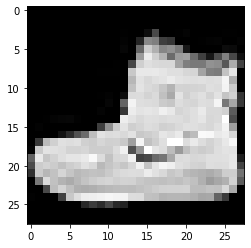

In [32]:
plt.imshow(images[0].squeeze(), cmap='gray')
print(labels[0])

Lets define our Neural Network class now. We have to create a class that extends nn.Module class

In [33]:
class Network(nn.Module):
    
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1 , out_channels=6, kernel_size=5)   #First layer in_channel=1 since our input has only 1 channel
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        ##Fully connectd layers below
        self.fc1=nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2=nn.Linear(in_features=120, out_features=60)
        self.out=nn.Linear(in_features=60, out_features=10)   ##Since we have 10 classes to predict 
        
    def forward(self, t):
            # (1) input layer
            t = t

            # (2) hidden conv layer
            t = self.conv1(t)
            t = F.relu(t)
            t = F.max_pool2d(t, kernel_size=2, stride=2)

            # (3) hidden conv layer
            t = self.conv2(t)
            t = F.relu(t)
            t = F.max_pool2d(t, kernel_size=2, stride=2)

            # (4) hidden linear layer
            t = t.reshape(-1, 12 * 4 * 4)
            t = self.fc1(t)
            t = F.relu(t)

            # (5) hidden linear layer
            t = self.fc2(t)
            t = F.relu(t)

            # (6) output layer
            t = self.out(t)
            #t = F.softmax(t, dim=1)

            return t
        

https://deeplizard.com/learn/video/cin4YcGBh3Q
How to calculate the output size of our tensor when it comes out of CNN. How did we know that output of our second CNN and input of our first linear layer would be 12*4*4 ? Check the URL


In [34]:
network=Network()

optimizer = optim.Adam(network.parameters(), lr=0.01)
grid = torchvision.utils.make_grid(images)
tb = SummaryWriter()
tb.add_image('images', grid)
tb.add_graph(network, images)

In [35]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

The above function takes preds an labels as tensors and checks how many predictions were actually true
Remember labeles are 1D arrays of length of the batch but preds are [batches X 10]


In [37]:
for epoch in range(10):
    total_loss=0
    total_correct=0
    for batch in train_loader:
        images,labels=batch
        preds=network(images)
        loss = F.cross_entropy(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss= total_loss+ loss.item()
        total_correct=total_correct+ get_num_correct(preds,labels)
    tb.add_scalar('Loss', total_loss, epoch)
    tb.add_scalar('Number Correct', total_correct, epoch)
    tb.add_scalar('Accuracy', total_correct / len(train_set), epoch)

    tb.add_histogram('conv1.bias', network.conv1.bias, epoch)
    tb.add_histogram('conv1.weight', network.conv1.weight, epoch)
    tb.add_histogram(
        'conv1.weight.grad'
        ,network.conv1.weight.grad
        ,epoch
    )
    print(
        "epoch:", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss
    )
tb.close()

epoch: 0 total_correct: 46749 loss: 352.16626474261284
epoch: 1 total_correct: 51162 loss: 240.68973118066788
epoch: 2 total_correct: 51762 loss: 221.64709624648094
epoch: 3 total_correct: 52125 loss: 211.5208581984043
epoch: 4 total_correct: 52378 loss: 205.71297426521778
epoch: 5 total_correct: 52478 loss: 203.5812717974186
epoch: 6 total_correct: 52814 loss: 194.7864325940609
epoch: 7 total_correct: 52801 loss: 195.06331293284893
epoch: 8 total_correct: 52888 loss: 191.9291991367936
epoch: 9 total_correct: 52952 loss: 189.80868123471737
